In [36]:
import sys 
sys.path.insert(0,"/gpfswork/rech/omr/uen17sn/NewSpinUp/lib/sklearnGPmodel")
sys.path.insert(0,"/gpfswork/rech/omr/uen17sn/NewSpinUp/lib")
import sklearnGPmodel as skgp
import analyseModel as analyse

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed, parallel_backend

import importlib
importlib.reload(skgp)
importlib.reload(analyse)

<module 'analyseModel' from '/gpfswork/rech/omr/uen17sn/NewSpinUp/lib/analyseModel.py'>

## **Simulation Loading**

In [80]:
simu_nb = 204
df = pd.read_csv(f"/gpfswork/rech/omr/uen17sn/NewSpinUp/datasets/yearly/dataFrame/simu{simu_nb}")
df.shape

(600, 18)

## **Forecast one simu and one EOF**

### 2.1 - Select parameters

In [81]:
gp_model    = skgp.defineGP()
eof1        = df["MSFT-1"]
norm        = True
window_size = 16  ### what we want to forecast mean or mean + variance ??
y           = window_size//2
show        = True
f           = 1.96 #intervalle de confiance 90% des valeurs plus proche moy #1.96 95%
out         = 5 #Number of predictions out of the intervalle ok before not ok

### 2.2 - Apply Auto-Regression model

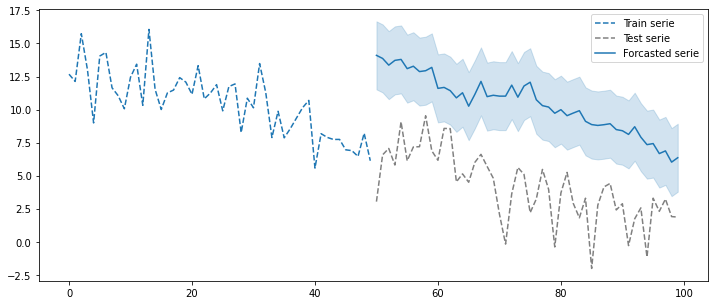

dict_keys(['ma_true', 'ma_pred', 'dist', 'dist_max', 'mse', 'std_true'])

In [82]:
train_len = 140 #250   #300 years for y
n_lags    = 50    # Nombre de retards (lags) pour l'autorégression
steps     = 50

mean_preds,std_preds,metrics = skgp.predictAuto(eof       = eof1,
                                                process   = gp_model,
                                                train_len = train_len,
                                                nlags     = n_lags,
                                                steps     = steps,
                                                norm      = False,
                                                show      = True,
                                                w         = window_size)

metrics.keys()

### 3.1 - Std interval

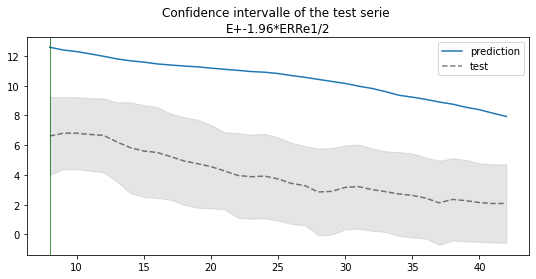

In [83]:
correct_years = analyse.goodPred(metrics,out=5,f=1.96,evaluation_method="std")


fig  = plt.figure(figsize=(9,4))  

axis = np.arange(y,(len(metrics["ma_pred"])+y))
plt.plot(axis, metrics["ma_pred"], color="tab:blue",label="prediction")
plt.plot(axis, metrics["ma_true"], linestyle="dashed",color="black",alpha=0.5,label="test")
plt.fill_between(
    axis,
    metrics["ma_true"]-f*np.sqrt(metrics["std_true"]),
    metrics["ma_true"]+f*np.sqrt(metrics["std_true"]),
    color = "tab:grey",
    alpha = 0.2)  

plt.axvline(correct_years,color = "darkgreen",linewidth=0.7)

plt.legend()
plt.title(f"Confidence intervalle of the test serie \nE+-{f}*ERRe1/2");

## **Analyse Models**

### 3.1 - Analyse correct predictions

In [84]:
n_lags     = 50    # Nombre de retards (lags) pour l'autorégression
steps      = 50
train_lens = np.arange(110,540,2) #lags + steps a -steps   

result       = Parallel(n_jobs=10)(delayed(skgp.predictAuto)(eof1,gp_model,i,n_lags,steps,norm=False,show=False) for i in train_lens)
correct_pred = [analyse.goodPred(result[i][2],out=out,f=f) for i in range(len(train_lens))]
#mse2     = [res2[i][2]["mse"] for i in range(trains_lens)]

/gpfslocalsup/pub/anaconda-py3/2021.05/envs/pytorch-gpu-1.10.1+py3.9.7/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/gpfslocalsup/pub/anaconda-py3/2021.05/envs/pytorch-gpu-1.10.1+py3.9.7/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/gpfslocalsup/pub/anaconda-py3/2021.05/envs/pytorch-gpu-1.10.1+py3.9.7/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lo

In [85]:
print(f"Nb of samples: {len(correct_pred)}")
print(f"Average nb of years correctly pred: {np.mean(correct_pred)}")
print()
tri    = sorted(correct_pred)
values = [0.1,0.25,0.5,0.75,0.95]
for val in values:
    ye = tri[int(len(tri) * val)]
    print(f"{val*100}% of correct predictions < {ye} years")

Nb of samples: 215
Average nb of years correctly pred: 20.176744186046513

10.0% of correct predictions < 8 years
25.0% of correct predictions < 8 years
50.0% of correct predictions < 14 years
75.0% of correct predictions < 32 years
95.0% of correct predictions < 43 years


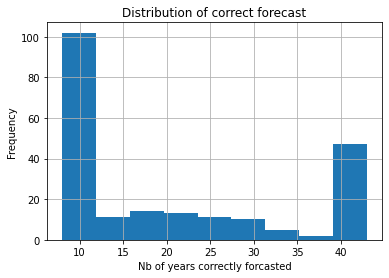

In [86]:
plt.hist(correct_pred, bins='auto')
plt.title('Distribution of correct forecast')
plt.xlabel('Nb of years correctly forcasted')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

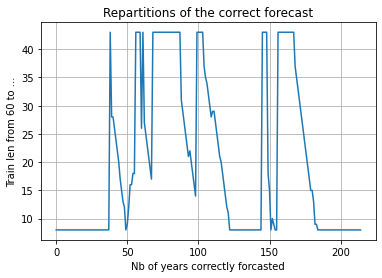

In [87]:
plt.plot(correct_pred)
plt.title('Repartitions of the correct forecast')
plt.xlabel('Nb of years correctly forcasted')
plt.ylabel('Train len from 60 to ...')
plt.grid(True)
plt.show()

In [88]:
r=np.array(correct_pred)
print("8 à 18 ans:    ",np.count_nonzero((r > 0)  & (r <= 8)) /len(r)*100,"%")
print("8 à 18 ans:    ",np.count_nonzero((r > np.mean(correct_pred))) /len(r)*100,"%")

8 à 18 ans:     44.651162790697676 %
8 à 18 ans:     39.53488372093023 %
